In [1]:
### 导入所需包
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from lifelines import KaplanMeierFitter
from matplotlib.ticker import MaxNLocator

# python matplotlib export editable PDF 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
# 设置全局字体为 Arial
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.dpi']= 180 

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import warnings
warnings.filterwarnings('ignore')

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [3]:
from lifelines import CoxPHFitter
import numpy as np

def calculate_survival_stats(Data, OS, Status, Group):
    """
    计算生存分析的统计量：
    - 两组：log-rank test p值和风险比(HR)
    - 多组：log-rank test p值
    
    参数:
    Data: DataFrame, 包含生存数据
    OS: str, 生存时间列名
    Status: str, 状态列名 (0=删失, 1=事件)
    Group: str, 分组列名
    
    返回:
    dict: 包含统计结果的字典
    """
    from lifelines.statistics import multivariate_logrank_test, logrank_test
    import pandas as pd
    
    groups = Data[Group].unique()
    stats = {}
    
    # 计算总体 log-rank test（适用于任意组数）
    results_multi = multivariate_logrank_test(
        Data[OS],
        Data[Group],
        Data[Status]
    )
    stats['overall_p_value'] = results_multi.p_value
    
    # 如果是两组比较，额外计算HR
    if len(groups) == 2:
        # 计算两组间的 log-rank test
        g1_mask = (Data[Group] == groups[0])
        g2_mask = (Data[Group] == groups[1])
        
        results = logrank_test(
            Data[OS][g1_mask], 
            Data[OS][g2_mask],
            Data[Status][g1_mask], 
            Data[Status][g2_mask]
        )
        stats['p_value'] = results.p_value
        
        # 计算HR和95% CI
        try:
            # 创建数值型分组变量
            temp_data = pd.DataFrame({
                'time': Data[OS],
                'event': Data[Status],
                'group': (Data[Group] == groups[1]).astype(int)  # 转换为0/1
            })
            
            # 拟合Cox模型
            cph = CoxPHFitter()
            cph.fit(temp_data, duration_col='time', event_col='event')
            
            # 获取回归系数和标准误差
            coef = cph.params_['group']  # 获取分组变量的回归系数
            se = cph.standard_errors_['group']  # 获取标准误差
            
            # 计算HR和95% CI
            hr = np.exp(coef)
            hr_ci_lower = np.exp(coef - 1.96 * se)
            hr_ci_upper = np.exp(coef + 1.96 * se)
            
            stats.update({
                'hr': hr,
                'hr_ci_lower': hr_ci_lower,
                'hr_ci_upper': hr_ci_upper
            })
            
        except Exception as e:
            print(f"计算HR时出错: {str(e)}")
            stats.update({
                'hr': None,
                'hr_ci_lower': None,
                'hr_ci_upper': None
            })
    
    return stats


def format_stats_text(stats, p_value_threshold=0.001):
    """
    格式化统计结果文本
    
    参数:
    stats: dict, 统计结果字典
    p_value_threshold: float, p值显示阈值
    
    返回:
    str: 格式化的统计文本
    """
    if not stats:
        return ""
    
    # 格式化总体p值
    if stats['overall_p_value'] < p_value_threshold:
        overall_p_text = f"Log-rank P < {p_value_threshold}"
    else:
        overall_p_text = f"Log-rank P = {stats['overall_p_value']:.3f}"
    
    # 如果是两组比较，添加HR信息
    if 'hr' in stats and all(v is not None for v in [stats.get('hr'), stats.get('hr_ci_lower'), stats.get('hr_ci_upper')]):
        hr_text = f"HR = {stats['hr']:.2f} (95% CI: {stats['hr_ci_lower']:.2f}-{stats['hr_ci_upper']:.2f})"
        return f"{overall_p_text}\n{hr_text}"
    else:
        return overall_p_text

# plot_survival_curve 函数保持不变，只需更新统计信息的显示位置
def plot_survival_curve(Data, OS, Status, Group, palette, at_risk_counts=True, 
                       show_censors=False, legend=True, title=None, xlabel=None, 
                       ylabel=None, show_grid=False, figsize=(10, 6), ax=None, 
                       censor_marker_size=9, set_xlim=None, x_bins=5):
    """绘制 Kaplan-Meier 生存曲线"""
    
    # 如果没有传入ax对象，创建一个新的
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # 获取唯一分组并创建颜色映射
    groups = Data[Group].unique()
    colors = sns.color_palette(palette, n_colors=len(groups))
    
    # 存储所有 KM 估计器
    kmfs = []
    
    # 为每个组绘制生存曲线
    for i, group in enumerate(groups):
        mask = (Data[Group] == group)
        group_data = Data[mask]
        
        kmf = KaplanMeierFitter()
        kmf.fit(group_data[OS], 
                event_observed=group_data[Status], 
                label=f'{group} (n={len(group_data)})')
        
        # 手动绘制生存曲线
        time_points = kmf.survival_function_.index.values
        survival_prob = kmf.survival_function_.iloc[:, 0].values
        
        # 绘制主线
        ax.step(time_points, survival_prob, where='post', 
                color=colors[i], label=f'{group} (n={len(group_data)})')
        
        # 如果需要显示删失点
        if show_censors:
            censored_mask = ~group_data[Status].astype(bool)
            censored_times = group_data[OS][censored_mask]
            if len(censored_times) > 0:
                censored_probs = []
                for t in censored_times:
                    if t in kmf.survival_function_.index:
                        prob = kmf.survival_function_.iloc[
                            kmf.survival_function_.index.get_loc(t), 0]
                    else:
                        idx = kmf.survival_function_.index.searchsorted(t) - 1
                        if idx >= 0:
                            prob = kmf.survival_function_.iloc[idx, 0]
                        else:
                            prob = 1.0
                    censored_probs.append(prob)
                
                ax.plot(censored_times, censored_probs, '+', 
                       color=colors[i], markersize=censor_marker_size)
        
        kmfs.append(kmf)
    
    # 添加风险表
    if at_risk_counts:
        from lifelines.plotting import add_at_risk_counts
        try:
            add_at_risk_counts(*kmfs, ax=ax)
        except Exception as e:
            print(f"无法添加风险表: {str(e)}")

    # 计算并添加统计信息
    stats = calculate_survival_stats(Data, OS, Status, Group)
    if stats:
        stats_text = format_stats_text(stats)
        # 对于多组比较，将p值显示在图的右上角
        if len(groups) > 2:
            ax.text(0.6, 0.45, stats_text, transform=ax.transAxes,
                   bbox=dict(facecolor='white', alpha=0.05, edgecolor='none'),
                   horizontalalignment='right',
                   verticalalignment='top')
        else:
            # 两组比较时保持在左下角
            ax.text(0.05, 0.08, stats_text, transform=ax.transAxes,
                   bbox=dict(facecolor='white', alpha=0.05, edgecolor='none'))
    
    # 设置图形属性
    ax.set_xlabel(xlabel if xlabel else '时间')
    ax.set_ylabel(ylabel if ylabel else '生存概率')
    
    if title:
        ax.set_title(title)
    
    # 设置图例
    if legend:
        ax.legend(title=None, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fancybox=True, shadow=True)
    
    # 添加网格
    if show_grid:
        ax.grid(True, alpha=0.3)
    
    # 设置y轴范围
    ax.set_ylim(-0.06, 1.05)

    if set_xlim:
        ax.set_xlim(set_xlim)

    # 设置x轴的主刻度间隔为10
    ax.xaxis.set_major_locator(MaxNLocator(nbins=x_bins))

    # 设置y轴的主刻度间隔为10
    # ax.yaxis.set_major_locator(MaxNLocator(nbins=10))

    # 调整主、副刻度参数
    # ax.minorticks_on()
    ax.tick_params(axis="both", which="major", direction="out", width=1, length=3.5)
    # ax.tick_params(axis="both", which="minor", direction="in", width=1, length=3)
    
    return ax

In [4]:
def plot_multiple_survival_curves(data_dict, OS, Status, Group, palette, 
                                  title, xlabel, ylabel, show_censors, censor_marker_size, 
                                  at_risk_counts, grid_size, figsize, output_pdf, set_xlim=None, 
                                  x_bins=5, os_pfs_type = "OS"):
    """
    data_dict: 字典，键为肿瘤类型，值为对应的数据
    """
    
    # 创建子图
    nrows, ncols = grid_size[0], grid_size[1]
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=400)
    axes = axes.ravel()  # Flatten the 2D axes array to 1D
    
    # 排序字典的键
    sorted_keys = sorted(data_dict.keys())

    # 遍历字典中的每个肿瘤类型及其数据
    for idx, (tumor_type, tumor_data) in enumerate(data_dict.items()):
        if idx >= len(axes):  # 超出子图数量，跳过
            break
        
        ax = axes[idx]
        
        # 绘制单个肿瘤类型的生存曲线
        try:
            plot_survival_curve(
                tumor_data, 
                OS=OS,           # 时间列
                Status=Status,   # 事件列
                Group=Group,     # 分组列
                palette=palette, 
                at_risk_counts=at_risk_counts, 
                show_censors=show_censors, 
                title=f'{tumor_type} ({os_pfs_type})', 
                xlabel=xlabel, 
                ylabel=ylabel, 
                censor_marker_size=censor_marker_size,
                set_xlim=set_xlim,
                x_bins=x_bins,
                ax=ax  # 传递轴对象
            )
        except Exception as e:
            print(f"绘制 {tumor_type} 生存曲线时发生错误: {e}")
    
    # 设置总标题
    fig.suptitle(title, fontsize=16, y=1.05)
    
    # 调整布局
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # 保存到PDF
    if output_pdf:
        plt.savefig(output_pdf, format='pdf')
    
    # 显示图形
    plt.show()

In [9]:
data = pd.read_csv("/Volumes/Extreme_Pro/Samsung_T5/pan-cancer/基于基因蛋白组的泛癌研究/Data/3-Transcriptomics/cNMF/cNMF_v2/TF_subtype.csv", index_col=0)
data

Cohort_ID   Sample_ID tumor/nat          WES cluster          CNV  \
0        10-TCL   PTCL_001T     tumor        AI_41      c1        AI_41   
1       44-ESCC   ESCC_130T     tumor  S2009_04250      c1  S2009_04250   
2       44-ESCC   ESCC_128T     tumor  S2009_03628      c3  S2009_03628   
3       44-ESCC   ESCC_127T     tumor  S2009_03490      c3  S2009_03490   
4       44-ESCC   ESCC_126T     tumor  S2009_03389      c3  S2009_03389   
...         ...         ...       ...          ...     ...          ...   
1080  35-Glioma  Glioma_10T     tumor    Exp031496      c0    Exp031496   
1081  35-Glioma  Glioma_11T     tumor    Exp031497      c3    Exp031497   
1082  35-Glioma  Glioma_13T     tumor    Exp031500      c0    Exp031500   
1083      33-PT     PT_192T     tumor   PitNET_192      c1   PitNET_192   
1084      33-PT     PT_157T     tumor   PitNET_157      c0   PitNET_157   

        Exp-Pro    Cluster  Gender Age  ... Tissue_Source Patients  \
0     Exp050645  Cluster_1  Female   2  ...         Blood      269   
1     ESCC_130T  Cluster_1    Male   3  ...    Esophageal      293   
2     ESCC_128T  Cluster_1    Male   3  ...    Esophageal      293   
3     ESCC_127T  Cluster_1    Male   2  ...    Esophageal      293   
4     ESCC_126T  Cluster_1    Male   3  ...    Esophageal      293   
...         ...        ...     ...  ..  ...           ...      ...   
1080  Exp031496  Cluster_6  Female   2  ...         Brain      226   
1081  Exp031497  Cluster_6  Female   3  ...         Brain      226   
1082  Exp031500  Cluster_6    Male   3  ...         Brain      226   
1083  Exp090134  Cluster_6    Male   0  ...         Brain      200   
1084  Exp094647  Cluster_6    Male   0  ...         Brain      200   

       Tumor_Type TF_Cluster      RNA_y   Exp-Phos Status     OS  \
0             TCL  Cluster_1   PTCL_001  Exp084808    1.0  10.39   
1            ESCC  Cluster_2   ESCC130T  Exp082200    0.0  81.00   
2            ESCC  Cluster_3   ESCC128T  Exp082199    0.0  82.00   
3            ESCC  Cluster_6   ESCC127T  Exp085690    1.0   8.00   
4            ESCC  Cluster_6   ESCC126T  Exp082198    0.0  82.00   
...           ...        ...        ...        ...    ...    ...   
1080  LGG and HGG  Cluster_4  Exp031496        NaN    1.0  17.00   
1081  LGG and HGG  Cluster_4  Exp031497  Exp031497    0.0   7.00   
1082  LGG and HGG  Cluster_4  Exp031500  Exp031500    0.0   3.00   
1083           PT  Cluster_3      C7952  Exp090363    NaN    NaN   
1084           PT  Cluster_2      C6843  Exp090555    NaN    NaN   

     PFS_DFS_Status PFS_DFS  
0               NaN     NaN  
1               0.0    81.0  
2               0.0    82.0  
3               1.0     1.0  
4               0.0    82.0  
...             ...     ...  
1080            NaN     NaN  
1081            1.0     6.0  
1082            0.0     3.0  
1083            NaN     NaN  
1084            NaN     NaN  

[1085 rows x 24 columns]

In [10]:
data1 = data.copy()
data1 = data1.dropna(subset=['OS','Status','TF_Cluster']) 
data1

Cohort_ID   Sample_ID tumor/nat          WES cluster          CNV  \
0        10-TCL   PTCL_001T     tumor        AI_41      c1        AI_41   
1       44-ESCC   ESCC_130T     tumor  S2009_04250      c1  S2009_04250   
2       44-ESCC   ESCC_128T     tumor  S2009_03628      c3  S2009_03628   
3       44-ESCC   ESCC_127T     tumor  S2009_03490      c3  S2009_03490   
4       44-ESCC   ESCC_126T     tumor  S2009_03389      c3  S2009_03389   
...         ...         ...       ...          ...     ...          ...   
1078  35-Glioma   Glioma_4T     tumor    Exp030509      c3    Exp030509   
1079  35-Glioma   Glioma_6T     tumor    Exp031273      c0    Exp031273   
1080  35-Glioma  Glioma_10T     tumor    Exp031496      c0    Exp031496   
1081  35-Glioma  Glioma_11T     tumor    Exp031497      c3    Exp031497   
1082  35-Glioma  Glioma_13T     tumor    Exp031500      c0    Exp031500   

        Exp-Pro    Cluster  Gender Age  ... Tissue_Source Patients  \
0     Exp050645  Cluster_1  Female   2  ...         Blood      269   
1     ESCC_130T  Cluster_1    Male   3  ...    Esophageal      293   
2     ESCC_128T  Cluster_1    Male   3  ...    Esophageal      293   
3     ESCC_127T  Cluster_1    Male   2  ...    Esophageal      293   
4     ESCC_126T  Cluster_1    Male   3  ...    Esophageal      293   
...         ...        ...     ...  ..  ...           ...      ...   
1078  Exp030509  Cluster_6  Female   2  ...         Brain      226   
1079  Exp031273  Cluster_6    Male   3  ...         Brain      226   
1080  Exp031496  Cluster_6  Female   2  ...         Brain      226   
1081  Exp031497  Cluster_6  Female   3  ...         Brain      226   
1082  Exp031500  Cluster_6    Male   3  ...         Brain      226   

       Tumor_Type TF_Cluster      RNA_y   Exp-Phos Status     OS  \
0             TCL  Cluster_1   PTCL_001  Exp084808    1.0  10.39   
1            ESCC  Cluster_2   ESCC130T  Exp082200    0.0  81.00   
2            ESCC  Cluster_3   ESCC128T  Exp082199    0.0  82.00   
3            ESCC  Cluster_6   ESCC127T  Exp085690    1.0   8.00   
4            ESCC  Cluster_6   ESCC126T  Exp082198    0.0  82.00   
...           ...        ...        ...        ...    ...    ...   
1078  LGG and HGG  Cluster_4  Exp030509        NaN    0.0   2.00   
1079  LGG and HGG  Cluster_4  Exp031273        NaN    1.0  11.00   
1080  LGG and HGG  Cluster_4  Exp031496        NaN    1.0  17.00   
1081  LGG and HGG  Cluster_4  Exp031497  Exp031497    0.0   7.00   
1082  LGG and HGG  Cluster_4  Exp031500  Exp031500    0.0   3.00   

     PFS_DFS_Status PFS_DFS  
0               NaN     NaN  
1               0.0    81.0  
2               0.0    82.0  
3               1.0     1.0  
4               0.0    82.0  
...             ...     ...  
1078            NaN     NaN  
1079            1.0     6.0  
1080            NaN     NaN  
1081            1.0     6.0  
1082            0.0     3.0  

[748 rows x 24 columns]

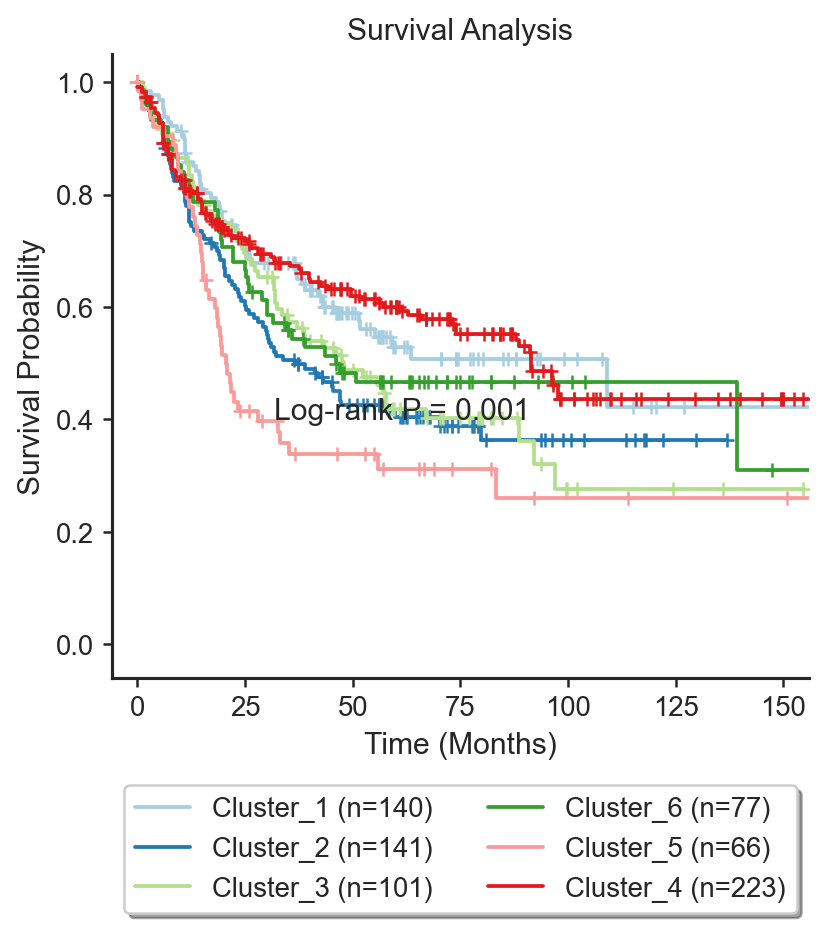

In [11]:
fig = plot_survival_curve(
    data1, 
    OS = 'OS', 
    Status = 'Status', 
    Group = 'TF_Cluster', 
    palette='Paired',
    title='Survival Analysis', 
    xlabel='Time (Months)', 
    ylabel='Survival Probability',
    at_risk_counts=False, 
    show_censors=True,
    figsize=(5, 4.5),
    censor_marker_size=5.65,
    set_xlim=(-6, 156),
    x_bins=7,
)

# plt.savefig("/Volumes/Extreme_Pro/Samsung_T5/pan-cancer/基于基因蛋白组的泛癌研究/Data/3-Transcriptomics/cNMF/cNMF_v2/figs/proteome_subtyping_NMF_OS_20250619.pdf")
plt.show()

In [12]:
icc_sat = pd.read_csv("/Volumes/Extreme_Pro/Samsung_T5/东方肝胆外科合作项目/data/RNA-seq/RNA_anatation_v3_boxplot.csv")
icc_sat

Sample_ID      Type Response (RECIST)       Response  Gender  Age  \
0   T_240147        NR                SD  Non_responder    Male   64   
1   T_241235        NR                SD  Non_responder    Male   51   
2   T_242038        NR                SD  Non_responder    Male   66   
3   T_242444        NR                SD  Non_responder  Female   78   
4   T_244938        NR                SD  Non_responder    Male   64   
5   T_248561        NR                SD  Non_responder  Female   70   
6   T_250599        NR                SD  Non_responder  Female   51   
7   T_252664        NR                SD  Non_responder    Male   51   
8   T_253154        NR                SD  Non_responder  Female   57   
9   T_258375        NR                SD  Non_responder    Male   48   
10  T_257310        NR                PD  Non_responder  Female   58   
11  T_238402   R_Chemo                PR      Responder    Male   57   
12  T_238867   R_Chemo                PR      Responder  Female   74   
13  T_239051   R_Chemo                PR      Responder    Male   54   
14  T_240194   R_Chemo                PR      Responder    Male   61   
15  T_240610   R_Chemo                PR      Responder  Female   63   
16  T_242062   R_Chemo                PR      Responder    Male   38   
17  T_242127   R_Chemo                PR      Responder    Male   64   
18  T_242471   R_Chemo                PR      Responder  Female   55   
19  T_250450   R_Chemo                PR      Responder  Female   34   
20  T_251611   R_Chemo                PR      Responder    Male   65   
21  T_249623  R_Immuno                PR      Responder    Male   66   
22  T_251610  R_Immuno                PR      Responder    Male   51   
23  T_252216  R_Immuno                PR      Responder    Male   65   
24  T_252234  R_Immuno                PR      Responder    Male   68   
25  T_259889  R_Immuno                PR      Responder  Female   67   
26  T_241815  R_Immuno                PR      Responder    Male   39   
27  T_241832  R_Immuno                PR      Responder  Female   46   
28  T_183331  R_Immuno                CR      Responder    Male   59   
29  T_237916  R_Immuno                CR      Responder    Male   61   

           OS  Status        PFS  progress  ...    HLA-DPB1        IDO1  \
0    5.000000       1   5.000000         1  ...   14.834029    0.506806   
1    3.000000       1   2.000000         1  ...   27.218682    2.016587   
2    5.833333       1   2.933333         1  ...   28.188627    0.117883   
3    8.333333       1   6.333333         1  ...   13.047819    0.478222   
4   12.866667       1   5.300000         1  ...   34.023708    0.561368   
5   13.366667       1  12.366667         1  ...   39.355571    1.896017   
6   15.433333       0   5.800000         1  ...   26.652045    0.366070   
7   13.133333       0  13.133333         0  ...   24.484119    0.419525   
8   10.733333       1   4.566667         1  ...   25.185683    0.251375   
9    6.933333       0   6.933333         0  ...   52.362541    0.679714   
10   3.366667       1   1.900000         1  ...   48.826801    0.866322   
11  10.000000       0  10.000000         0  ...   17.043761    0.322369   
12   4.000000       1   4.000000         1  ...    3.726628    0.181735   
13   9.000000       0   6.000000         1  ...   18.166966    0.168021   
14   5.000000       1   5.000000         1  ...   16.696444    0.268206   
15   6.000000       1   6.000000         1  ...    8.447781    1.109735   
16   9.700000       1   7.666667         1  ...   16.925382    0.288234   
17   5.666667       1   5.666667         1  ...    8.389680    0.119481   
18   9.366667       1   5.266667         1  ...   18.143271    0.491979   
19  15.633333       0  15.633333         0  ...   22.989377    0.392304   
20  14.166667       0  14.166667         0  ...   29.143946    0.402033   
21  16.600000       0  16.600000         0  ...   48.735085    2.394222   
22  14.166667       0   7.300000         1  .

In [29]:
icc_sat_v2 = icc_sat[icc_sat['Type'].isin(['R_Chemo', 'R_Immuno'])]
icc_sat_v2

Sample_ID      Type Response (RECIST)   Response  Gender  Age         OS  \
11  T_238402   R_Chemo                PR  Responder    Male   57  10.000000   
12  T_238867   R_Chemo                PR  Responder  Female   74   4.000000   
13  T_239051   R_Chemo                PR  Responder    Male   54   9.000000   
14  T_240194   R_Chemo                PR  Responder    Male   61   5.000000   
15  T_240610   R_Chemo                PR  Responder  Female   63   6.000000   
16  T_242062   R_Chemo                PR  Responder    Male   38   9.700000   
17  T_242127   R_Chemo                PR  Responder    Male   64   5.666667   
18  T_242471   R_Chemo                PR  Responder  Female   55   9.366667   
19  T_250450   R_Chemo                PR  Responder  Female   34  15.633333   
20  T_251611   R_Chemo                PR  Responder    Male   65  14.166667   
21  T_249623  R_Immuno                PR  Responder    Male   66  16.600000   
22  T_251610  R_Immuno                PR  Responder    Male   51  14.166667   
23  T_252216  R_Immuno                PR  Responder    Male   65   9.800000   
24  T_252234  R_Immuno                PR  Responder    Male   68  13.566667   
25  T_259889  R_Immuno                PR  Responder  Female   67   5.633333   
26  T_241815  R_Immuno                PR  Responder    Male   39  13.933333   
27  T_241832  R_Immuno                PR  Responder  Female   46  10.233333   
28  T_183331  R_Immuno                CR  Responder    Male   59  10.000000   
29  T_237916  R_Immuno                CR  Responder    Male   61  10.000000   

    Status        PFS  progress  ...    HLA-DPB1        IDO1       LAG3  \
11       0  10.000000         0  ...   17.043761    0.322369   1.132123   
12       1   4.000000         1  ...    3.726628    0.181735   0.041485   
13       0   6.000000         1  ...   18.166966    0.168021   3.763534   
14       1   5.000000         1  ...   16.696444    0.268206   7.101982   
15       1   6.000000         1  ...    8.447781    1.109735   0.502622   
16       1   7.666667         1  ...   16.925382    0.288234   0.986938   
17       1   5.666667         1  ...    8.389680    0.119481   1.448945   
18       1   5.266667         1  ...   18.143271    0.491979   0.799094   
19       0  15.633333         0  ...   22.989377    0.392304   2.179103   
20       0  14.166667         0  ...   29.143946    0.402033   1.862450   
21       0  16.600000         0  ...   48.735085    2.394222   3.797951   
22       0   7.300000         1  ...   32.313304    3.907125   3.372959   
23       0   9.800000         0  ...   60.390747    1.487132   2.280821   
24       0  13.566667         0  ...    5.377796    0.339578   0.350073   
25       0   5.633333         0  ...   34.795357    6.790712   4.408630   
26       0  13.933333         0  ...  120.939488  350.762473  51.279580   
27       0  10.233333         0  ...  110.462860    4.581624   2.556170   
28       0  10.000000         0  ...    7.173645   13.802998   6.426440   
29       0  10.000000         0  ...  146.495542    4.071501   3.945612   

       TIGIT      ICOS       CD27      CD274  PDCD1LG2     CTLA4     HAVCR2  
11  0.213005  0.295988   0.392561   0.779037  0.497911  0.646686   2.719774  
12  0.000000  0.024102   0.479494   0.401197  0.026065  0.000000   0.157881  
13  0.408921  0.139272   0.720380   0.820308  0.331344  0.136929   1.778970  
14  0.460763  0.047427   0.896346   0.926090  0.461597  0.174860   1.592179  
15  0.312700  0.280337   0.325328   2.692137  5.608471  0.401948   1.377248  
16  0.358819  0.365646   0.892743   2.553730  1.851262  0.674054   6.559424  
17  0.085526  0.316921   1.812645   0.836951  1.649352  0.194743   5.806224  
18  0.119194  0.163120   1.273087   1.397778  3.500865  0.154208   8.209005  
19  0.269583  0.208115   0.345022   1.243557  3.413391  0.085256   3.010499  
20  0.501074  0.219549   1.372714   0.883509  3.154338  0.308365   5.778243  
21  1.185142  1.560742   0.214135   3.100994  1.978811  1.12440

In [33]:
icc_sat_v3 = icc_sat[icc_sat['Type'].isin(['R_Chemo', 'NR'])]
icc_sat_v3

Sample_ID     Type Response (RECIST)       Response  Gender  Age  \
0   T_240147       NR                SD  Non_responder    Male   64   
1   T_241235       NR                SD  Non_responder    Male   51   
2   T_242038       NR                SD  Non_responder    Male   66   
3   T_242444       NR                SD  Non_responder  Female   78   
4   T_244938       NR                SD  Non_responder    Male   64   
5   T_248561       NR                SD  Non_responder  Female   70   
6   T_250599       NR                SD  Non_responder  Female   51   
7   T_252664       NR                SD  Non_responder    Male   51   
8   T_253154       NR                SD  Non_responder  Female   57   
9   T_258375       NR                SD  Non_responder    Male   48   
10  T_257310       NR                PD  Non_responder  Female   58   
11  T_238402  R_Chemo                PR      Responder    Male   57   
12  T_238867  R_Chemo                PR      Responder  Female   74   
13  T_239051  R_Chemo                PR      Responder    Male   54   
14  T_240194  R_Chemo                PR      Responder    Male   61   
15  T_240610  R_Chemo                PR      Responder  Female   63   
16  T_242062  R_Chemo                PR      Responder    Male   38   
17  T_242127  R_Chemo                PR      Responder    Male   64   
18  T_242471  R_Chemo                PR      Responder  Female   55   
19  T_250450  R_Chemo                PR      Responder  Female   34   
20  T_251611  R_Chemo                PR      Responder    Male   65   

           OS  Status        PFS  progress  ...   HLA-DPB1      IDO1  \
0    5.000000       1   5.000000         1  ...  14.834029  0.506806   
1    3.000000       1   2.000000         1  ...  27.218682  2.016587   
2    5.833333       1   2.933333         1  ...  28.188627  0.117883   
3    8.333333       1   6.333333         1  ...  13.047819  0.478222   
4   12.866667       1   5.300000         1  ...  34.023708  0.561368   
5   13.366667       1  12.366667         1  ...  39.355571  1.896017   
6   15.433333       0   5.800000         1  ...  26.652045  0.366070   
7   13.133333       0  13.133333         0  ...  24.484119  0.419525   
8   10.733333       1   4.566667         1  ...  25.185683  0.251375   
9    6.933333       0   6.933333         0  ...  52.362541  0.679714   
10   3.366667       1   1.900000         1  ...  48.826801  0.866322   
11  10.000000       0  10.000000         0  ...  17.043761  0.322369   
12   4.000000       1   4.000000         1  ...   3.726628  0.181735   
13   9.000000       0   6.000000         1  ...  18.166966  0.168021   
14   5.000000       1   5.000000         1  ...  16.696444  0.268206   
15   6.000000       1   6.000000         1  ...   8.447781  1.109735   
16   9.700000       1   7.666667         1  ...  16.925382  0.288234   
17   5.666667       1   5.666667         1  ...   8.389680  0.119481   
18   9.366667       1   5.266667         1  ...  18.143271  0.491979   
19  15.633333       0  15.633333         0  ...  22.989377  0.392304   
20  14.166667       0  14.166667         0  ...  29.143946  0.402033   

        LAG3     TIGIT      ICOS      CD27     CD274  PDCD1LG2     CTLA4  \
0   0.237312  0.632535  1.034069  2.160046  0.728228  0.764142  0.910770   
1   1.125253  0.598782  0.515083  2.010010  1.737600  1.478241  0.730411   
2   4.776423  0.354404  0.039085  1.321859  1.926762  4.057658  0.000000   
3   0.154255  0.190506  0.151665  1.042318  1.765418  1.983061  0.406673   
4   2.702181  0.335443  0.356068  1.094746  1.201970  2.590384  0.238690   
5   1.985986  0.529132  0.907153  3.482754  0.927198  1.514540  0.723685   
6   1.462364  0.279506  0.215776  1.609749  1.467766  2.741781  0.165739   
7   2.259476  0.870870  0.956293  1.003115  2.215169  2.068299  1.474414   
8   4.482972  0.683761  0.041673  1.575185  1.200581  2.929268  0.102430   
9   0.872774  0.401401  0.732437  1.288989  4.376556  4.498541  0.669338   
10  0.929459  0.689

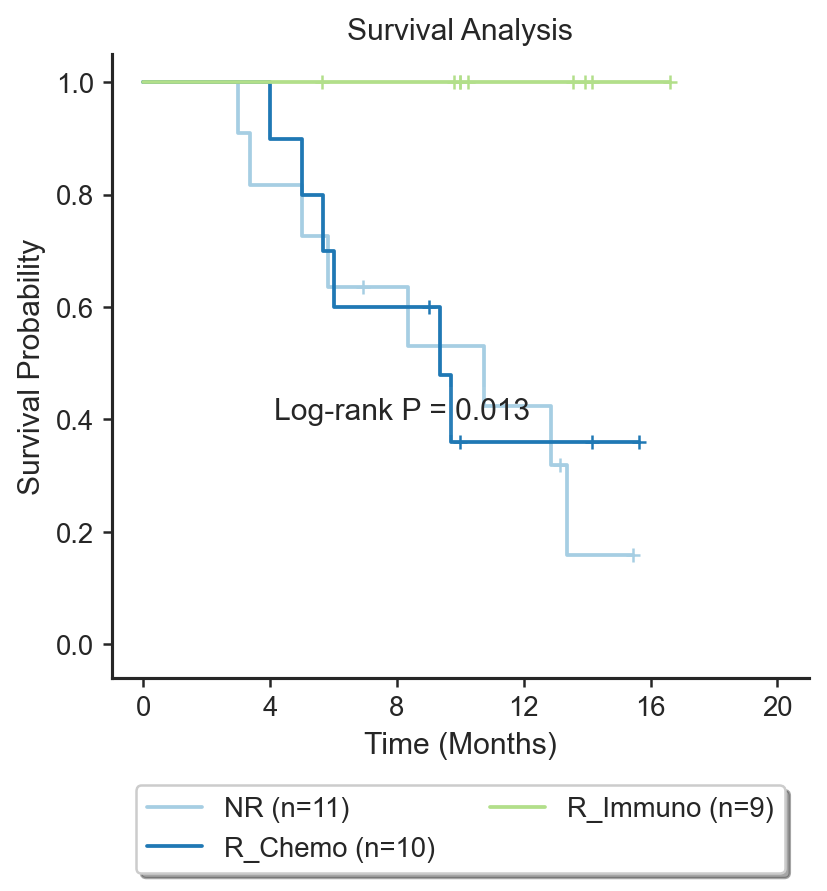

In [27]:
fig = plot_survival_curve(
    icc_sat, 
    OS = 'OS', 
    Status = 'Status', 
    Group = 'Type', 
    palette='Paired',
    title='Survival Analysis', 
    xlabel='Time (Months)', 
    ylabel='Survival Probability',
    at_risk_counts=False, 
    show_censors=True,
    figsize=(5, 4.5),
    censor_marker_size=5.65,
    set_xlim=(-1, 21),
    x_bins=7,
)

plt.savefig("./figs/iCC_SAT_subtyping_OS_20250720.pdf")
plt.show()

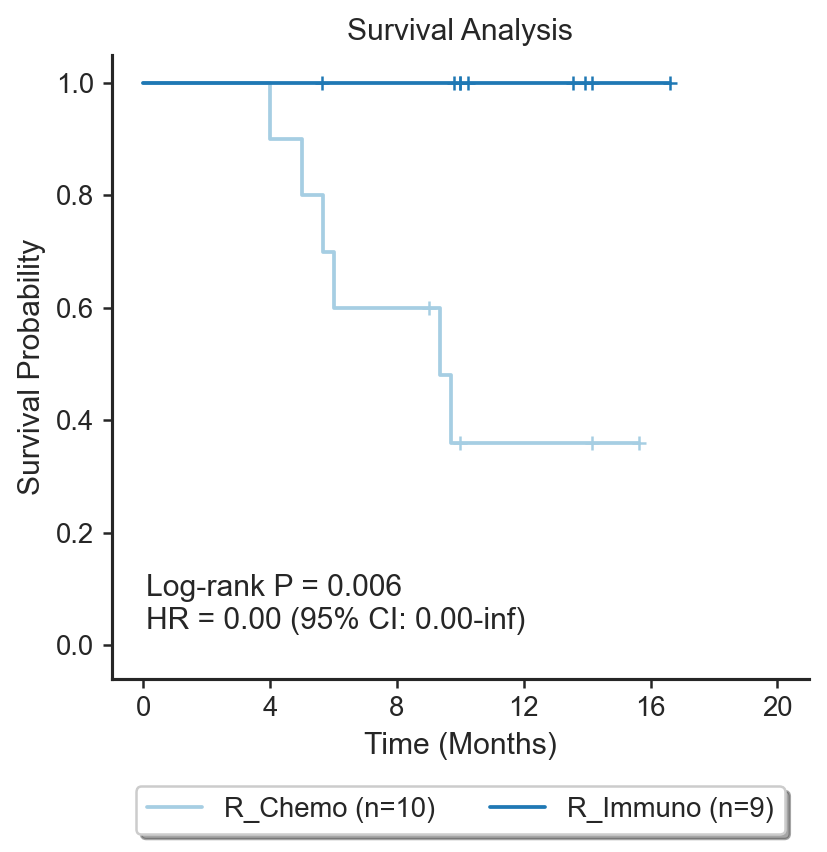

In [30]:
fig = plot_survival_curve(
    icc_sat_v2, 
    OS = 'OS', 
    Status = 'Status', 
    Group = 'Type', 
    palette='Paired',
    title='Survival Analysis', 
    xlabel='Time (Months)', 
    ylabel='Survival Probability',
    at_risk_counts=False, 
    show_censors=True,
    figsize=(5, 4.5),
    censor_marker_size=5.65,
    set_xlim=(-1, 21),
    x_bins=7,
)

plt.savefig("./figs/iCC_SAT_subtyping_Response_OS_20250720.pdf")
plt.show()

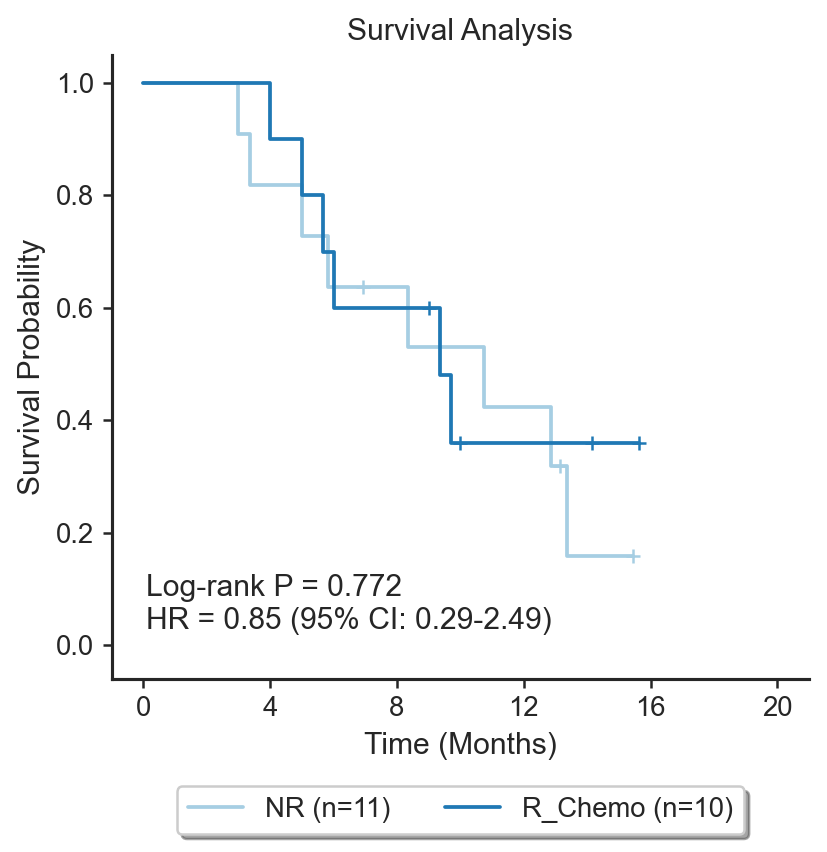

In [34]:
fig = plot_survival_curve(
    icc_sat_v3, 
    OS = 'OS', 
    Status = 'Status', 
    Group = 'Type', 
    palette='Paired',
    title='Survival Analysis', 
    xlabel='Time (Months)', 
    ylabel='Survival Probability',
    at_risk_counts=False, 
    show_censors=True,
    figsize=(5, 4.5),
    censor_marker_size=5.65,
    set_xlim=(-1, 21),
    x_bins=7,
)

plt.savefig("./figs/iCC_SAT_subtyping_NR_R_Chemo_OS_20250720.pdf")
plt.show()

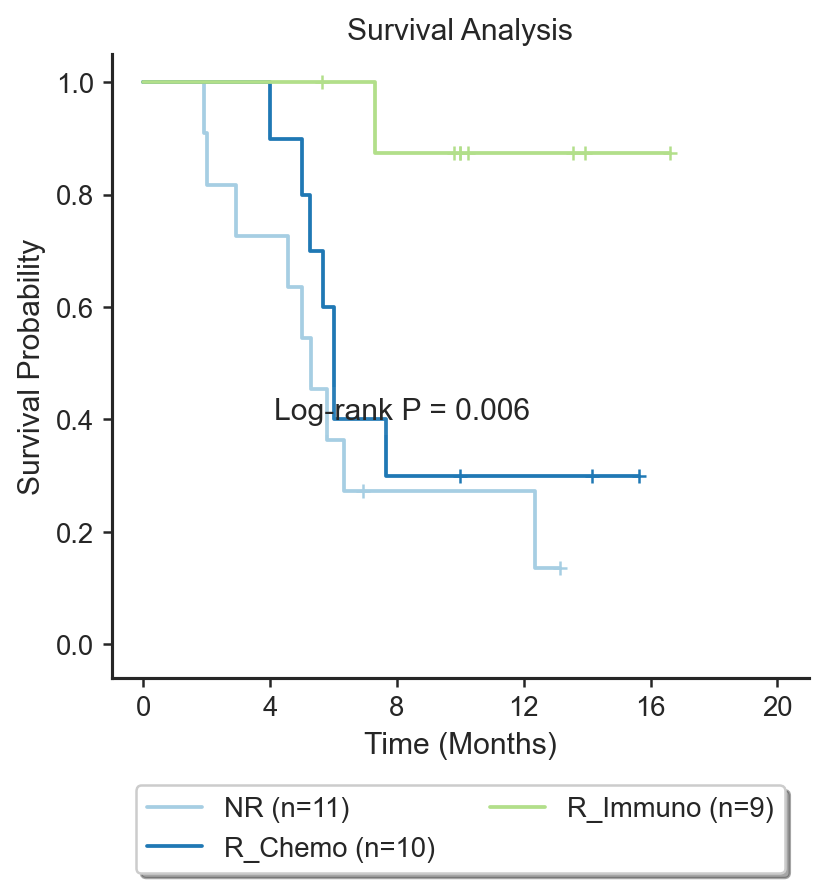

In [31]:
fig = plot_survival_curve(
    icc_sat, 
    OS = 'PFS', 
    Status = 'progress', 
    Group = 'Type', 
    palette='Paired',
    title='Survival Analysis', 
    xlabel='Time (Months)', 
    ylabel='Survival Probability',
    at_risk_counts=False, 
    show_censors=True,
    figsize=(5, 4.5),
    censor_marker_size=5.65,
    set_xlim=(-1, 21),
    x_bins=7,
)

plt.savefig("./figs/iCC_SAT_subtyping_PFS_20250720.pdf")
plt.show()

In [32]:
fig = plot_survival_curve(
    icc_sat_v2, 
    OS = 'PFS', 
    Status = 'progress', 
    Group = 'Type', 
    palette='Paired',
    title='Survival Analysis', 
    xlabel='Time (Months)', 
    ylabel='Survival Probability',
    at_risk_counts=False, 
    show_censors=True,
    figsize=(5, 4.5),
    censor_marker_size=5.65,
    set_xlim=(-1, 21),
    x_bins=7,
)

plt.savefig("./figs/iCC_SAT_subtyping_Response_PFS_20250720.pdf")
plt.show()

In [36]:
fig = plot_survival_curve(
    icc_sat_v3, 
    OS = 'PFS', 
    Status = 'progress', 
    Group = 'Type', 
    palette='Paired',
    title='Survival Analysis', 
    xlabel='Time (Months)', 
    ylabel='Survival Probability',
    at_risk_counts=False, 
    show_censors=True,
    figsize=(5, 4.5),
    censor_marker_size=5.65,
    set_xlim=(-1, 21),
    x_bins=7,
)

plt.savefig("./figs/iCC_SAT_subtyping_NR_R_Chemo_PFS_20250720.pdf")
plt.show()